<a href="https://colab.research.google.com/github/oliseh6123/LectureSakilaDatabase/blob/main/Lecture2Sakila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The Sakila Database**
One of the best example databases out there is the Sakila Database, which was originally created by MySQL and has been open sourced under the terms of the BSD License.

The Sakila database is a nicely normalised schema modelling a DVD rental store, featuring things like films, actors, film-actor relationships, and a central inventory table that connects films, stores, and rentals.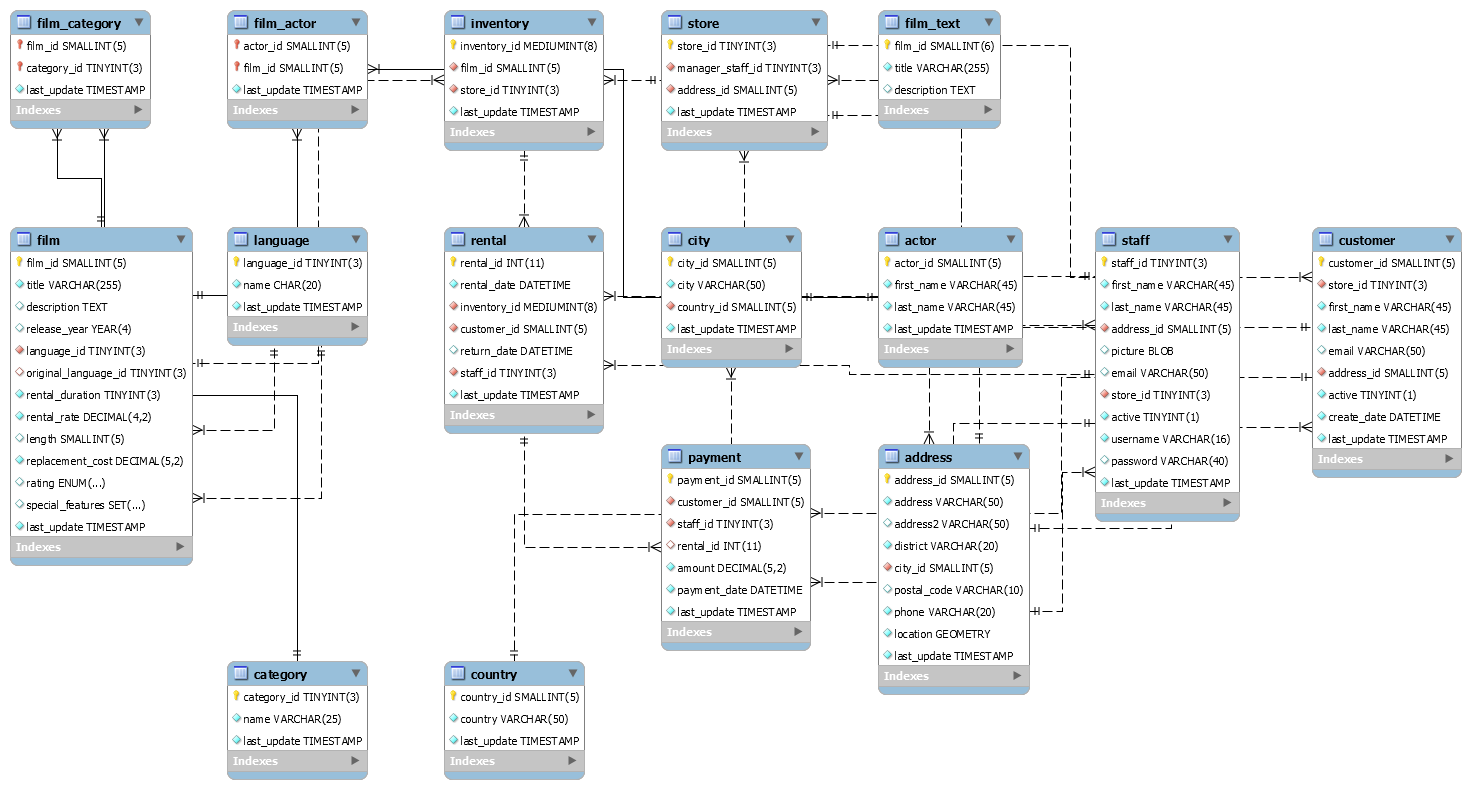

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

%matplotlib inline

In [4]:
conn = sqlite3.connect('data/sakila.db')

df = pd.read_sql('''
    SELECT
        rental.rental_id, rental.rental_date, rental.return_date,
        customer.last_name AS customer_lastname,
        store.store_id,
        city.city AS rental_store_city,
        film.title AS film_title, film.rental_duration AS film_rental_duration,
        film.rental_rate AS film_rental_rate, film.replacement_cost AS film_replacement_cost,
        film.rating AS film_rating
    FROM rental
    INNER JOIN customer ON rental.customer_id == customer.customer_id
    INNER JOIN inventory ON rental.inventory_id == inventory.inventory_id
    INNER JOIN store ON inventory.store_id == store.store_id
    INNER JOIN address ON store.address_id == address.address_id
    INNER JOIN city ON address.city_id == city.city_id
    INNER JOIN film ON inventory.film_id == film.film_id
    ;
''', conn, index_col='rental_id', parse_dates=['rental_date','return_date'])

## **The data at a glance**

In [5]:
df.head()

,rental_date,return_date,customer_lastname,store_id,rental_store_city,film_title,film_rental_duration,film_rental_rate,film_replacement_cost,film_rating
rental_id,,,,,,,,,,
1,2005-05-24 22:53:30,2005-05-26 22:04:30,HUNTER,1,Lethbridge,BLANKET BEVERLY,7,2.99,21.99,G
2,2005-05-24 22:54:33,2005-05-28 19:40:33,COLLAZO,2,Woodridge,FREAKY POCUS,7,2.99,16.99,R
3,2005-05-24 23:03:39,2005-06-01 22:12:39,MURRELL,2,Woodridge,GRADUATE LORD,7,2.99,14.99,G
4,2005-05-24 23:04:41,2005-06-03 01:43:41,PURDY,1,Lethbridge,LOVE SUICIDES,6,0.99,21.99,R
5,2005-05-24 23:05:21,2005-06-02 04:33:21,HANSEN,2,Woodridge,IDOLS SNATCHERS,5,2.99,29.99,NC-17


In [6]:
df.shape

(16044, 10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16044 entries, 1 to 16049
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   rental_date            16044 non-null  datetime64[ns]
 1   return_date            15861 non-null  datetime64[ns]
 2   customer_lastname      16044 non-null  object        
 3   store_id               16044 non-null  int64         
 4   rental_store_city      16044 non-null  object        
 5   film_title             16044 non-null  object        
 6   film_rental_duration   16044 non-null  int64         
 7   film_rental_rate       16044 non-null  float64       
 8   film_replacement_cost  16044 non-null  float64       
 9   film_rating            16044 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 1.3+ MB


In [8]:
df.describe()

,store_id,film_rental_duration,film_rental_rate,film_replacement_cost
count,16044.000000,16044.00000,16044.000000,16044.000000
mean,1.506171,4.93549,2.942630,20.215443
std,0.499978,1.40169,1.649678,6.081771
min,1.000000,3.00000,0.990000,9.990000
25%,1.000000,4.00000,0.990000,14.990000
50%,2.000000,5.00000,2.990000,20.990000
75%,2.000000,6.00000,4.990000,25.990000
max,2.000000,7.00000,4.990000,29.990000


## **Numerical analysis and visualization**
We'll analyze the film_rental_rate column:

In [9]:
df['film_rental_rate'].describe()

count    16044.000000
mean         2.942630
std          1.649678
min          0.990000
25%          0.990000
50%          2.990000
75%          4.990000
max          4.990000
Name: film_rental_rate, dtype: float64

In [10]:
df['film_rental_rate'].mean()

2.9426302667662574

In [11]:
df['film_rental_rate'].median()

2.99

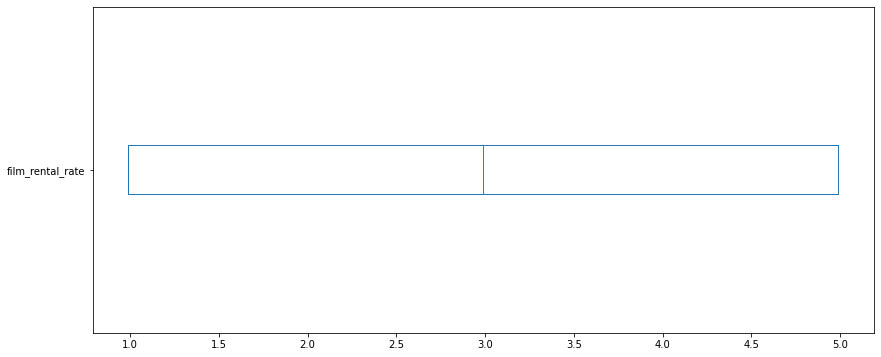

In [12]:
df['film_rental_rate'].plot(kind='box', vert=False, figsize=(14,6))

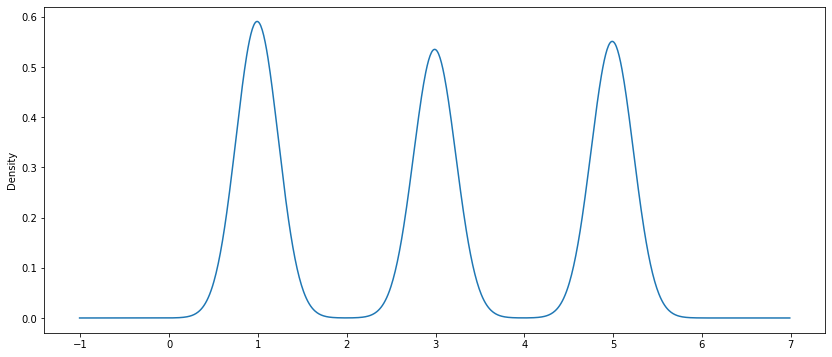

In [13]:
df['film_rental_rate'].plot(kind='density', figsize=(14,6))

Text(0, 0.5, 'Number of Rentals')

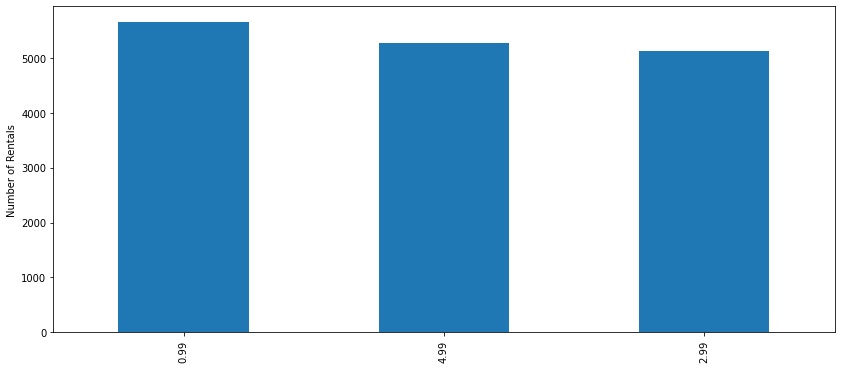

In [15]:
ax = df['film_rental_rate'].value_counts().plot(kind='bar', figsize=(14,6))
ax.set_ylabel('Number of Rentals')

### **Categorical analysis and visualization**
We'll analyze the rental_store_city column:

In [16]:
df['rental_store_city'].value_counts()

Woodridge     8121
Lethbridge    7923
Name: rental_store_city, dtype: int64

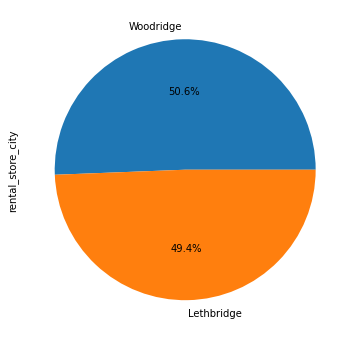

In [18]:
df['rental_store_city'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(14,6))

Text(0, 0.5, 'Number of Rentals')

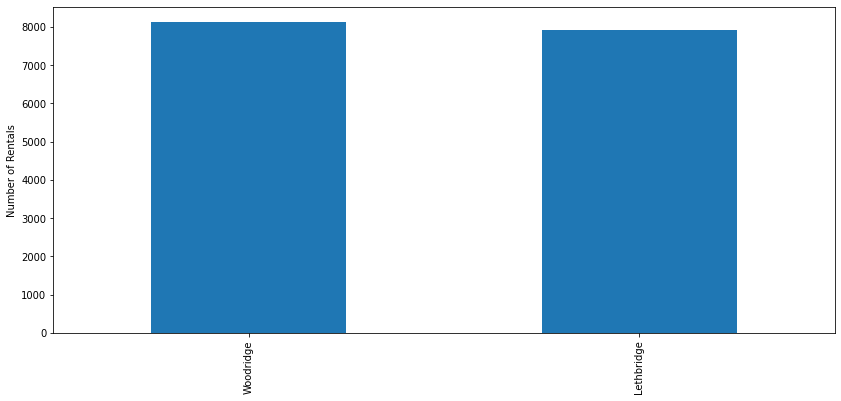

In [19]:
ax = df['rental_store_city'].value_counts().plot(kind='bar', figsize=(14,6))
ax.set_ylabel('Number of Rentals')

## **Column wrangling**
We can also create new columns or modify existing ones.

### **Add and calculate a new rental_rate_return column**
We want to know the rental rate of return of each film. To do that we'll use this formula:


In [20]:
df['rental_gain_return'] = df['film_rental_rate'] / df['film_replacement_cost'] * 100

df['rental_gain_return'].head()

rental_id
1    13.597090
2    17.598587
3    19.946631
4     4.502046
5     9.969990
Name: rental_gain_return, dtype: float64

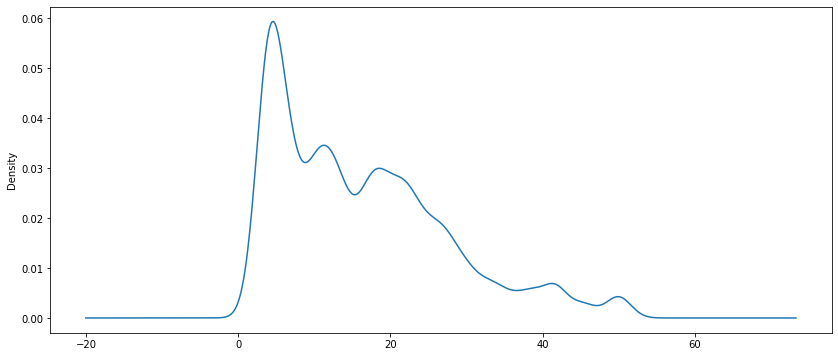

In [21]:
df['rental_gain_return'].plot(kind='density', figsize=(14,6))

In [26]:
df['rental_gain_return'].mean()

16.343824010240393

In [28]:
df['rental_gain_return'].median().round(2)

AttributeError: ignored

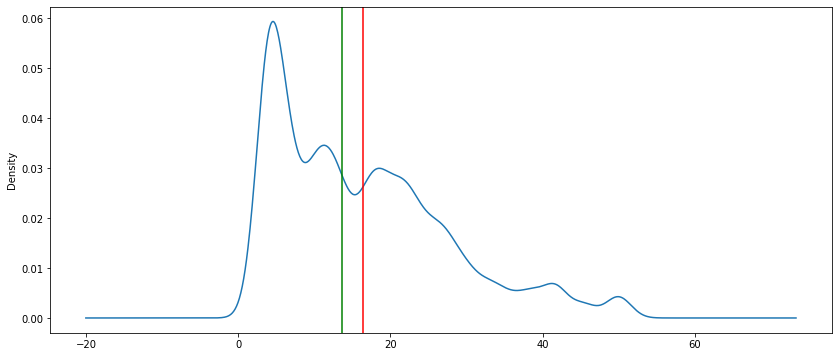

In [29]:
ax = df['rental_gain_return'].plot(kind='density', figsize=(14,6)) # kde
ax.axvline(df['rental_gain_return'].mean(), color='red')
ax.axvline(df['rental_gain_return'].median(), color='green')

Each rental represents **13.6%** of film cost.

So **7.35** rentals are needed to recover film market price (film_replacement_cost)

In [30]:
100/13.6

7.352941176470589

While in average each film is rented **16.74** times.

In [31]:
df['film_title'].value_counts().mean()

16.747390396659707

## **Selection & Indexing:**
### **Get the rental records of the customer with lastname HANSEN**

In [32]:
df.loc[df['customer_lastname'] == 'HANSEN']

,rental_date,return_date,customer_lastname,store_id,rental_store_city,film_title,film_rental_duration,film_rental_rate,film_replacement_cost,film_rating,rental_gain_return
rental_id,,,,,,,,,,,
5,2005-05-24 23:05:21,2005-06-02 04:33:21,HANSEN,2,Woodridge,IDOLS SNATCHERS,5,2.99,29.99,NC-17,9.969990
134,2005-05-25 21:48:41,2005-06-02 18:28:41,HANSEN,2,Woodridge,JUMPING WRATH,4,0.99,18.99,NC-17,5.213270
416,2005-05-27 15:02:10,2005-05-29 10:34:10,HANSEN,2,Woodridge,LESSON CLEOPATRA,3,0.99,28.99,NC-17,3.414971
809,2005-05-29 19:10:20,2005-06-05 19:05:20,HANSEN,2,Woodridge,INDIAN LOVE,4,0.99,26.99,NC-17,3.668025
1006,2005-05-31 00:57:08,2005-06-02 22:35:08,HANSEN,2,Woodridge,SALUTE APOLLO,4,2.99,29.99,R,9.969990
1368,2005-06-15 14:27:47,2005-06-23 18:07:47,HANSEN,1,Lethbridge,HUNCHBACK IMPOSSIBLE,4,4.99,28.99,PG-13,17.212832
2603,2005-06-19 06:21:25,2005-06-26 03:19:25,HANSEN,2,Woodridge,CAT CONEHEADS,5,4.99,14.99,G,33.288859
5209,2005-07-09 11:22:39,2005-07-17 09:31:39,HANSEN,1,Lethbridge,WHALE BIKINI,4,4.99,11.99,PG-13,41.618015
5266,2005-07-09 14:17:40,2005-07-16 10:42:40,HANSEN,2,Woodridge,LOATHING LEGALLY,4,0.99,29.99,R,3.301100


### **Create a list of all the films with the highest replacement cost**

In [33]:
df['film_replacement_cost'].max()

29.99

In [34]:
df.loc[df['film_replacement_cost'] == df['film_replacement_cost'].max(), 'film_title'].unique()

array(['IDOLS SNATCHERS', 'LAWLESS VISION', 'SONG HEDWIG',
       'LOATHING LEGALLY', 'PATIENT SISTER', 'RESERVOIR ADAPTATION',
       'JEEPERS WEDDING', 'GOLDFINGER SENSIBILITY', 'CHARIOTS CONSPIRACY',
       'HONEY TIES', 'GRAFFITI LOVE', 'SLACKER LIAISONS', 'DIRTY ACE',
       'BLINDNESS GUN', 'WYOMING STORM', 'FEUD FROGMEN', 'SALUTE APOLLO',
       'JINGLE SAGEBRUSH', 'HILLS NEIGHBORS', 'UNCUT SUICIDES',
       'EVERYONE CRAFT', 'FLATLINERS KILLER', 'BALLROOM MOCKINGBIRD',
       'RIVER OUTLAW', 'ARABIA DOGMA', 'VIRGIN DAISY', 'JERICHO MULAN',
       'SASSY PACKER', 'TRACY CIDER', 'LOVER TRUMAN', 'DOCTOR GRAIL',
       'GILMORE BOILED', 'PRINCESS GIANT', 'CRUELTY UNFORGIVEN',
       'REIGN GENTLEMEN', 'WEST LION', 'BONNIE HOLOCAUST', 'EARTH VISION',
       'RANDOM GO', 'CLOCKWORK PARADISE', 'FANTASIA PARK', 'RIGHT CRANES',
       'CUPBOARD SINNERS', 'OSCAR GOLD', 'SMILE EARRING',
       'HOLLYWOOD ANONYMOUS', 'POSEIDON FOREVER',
       'EXTRAORDINARY CONQUERER', 'QUEST MUSSOLINI', 

### **How many PG or PG-13 rating films were rented?**

In [35]:
df.loc[(df['film_rating'] == 'PG') | (df['film_rating'] == 'PG-13')].shape[0]

6797